In [3]:
%pip install scikit-learn

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import jax.numpy as jnp
import jax
import jax.nn as nn
import jax.scipy.optimize
import matplotlib.pyplot as plt
data = pd.read_csv('creditcard.csv')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
data_np = data.to_numpy()
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), unit_variance=False)
data_np[:, [0, 29]] = scaler.fit_transform(data_np[:, [0, 29]])


In [6]:
fraud_data = data_np[data_np[:, -1] == 1]
print(fraud_data.shape)

(492, 31)


In [7]:
legit_data = data_np[data_np[:, -1] == 0]
legit_data_lim = legit_data[np.random.choice(legit_data.shape[0], 492, replace=False)]
print(legit_data_lim.shape)

(492, 31)


In [8]:
train_dataset = np.vstack((legit_data_lim, fraud_data))
np.random.shuffle(train_dataset)
print(legit_data_lim.shape[0]*2)
print(train_dataset.shape)

984
(984, 31)


In [9]:
train_labels = train_dataset[:, -1]
train_dataset = train_dataset[:, :-1]
print(train_labels.shape)
print(train_dataset.shape)

(984,)
(984, 30)


In [10]:
class SVM:
    def __init__(self, lmbda=1.0):
        self.lmbda = lmbda
        self.w = None

    def loss(self, params, X, y):
        # Compute the decision function Y = Xw + b
        decision = jnp.dot(X, params[:-1]) + params[-1]
        # Compute the hinge loss
        loss_val = jnp.maximum(0, 1 - y * decision)
        # Regularization term (L2 norm of w)
        reg_term = self.lmbda * jnp.sum(params ** 2)
        # Total loss
        return reg_term + jnp.mean(loss_val)

    def train(self, X, y):
        _, n_features = X.shape

        # Initialize weights and bias
        self.w = jnp.zeros(n_features + 1)

        # Solve optimization problem
        opt_res = jax.scipy.optimize.minimize(self.loss, self.w, method="BFGS", args=(X, y))
        self.w = opt_res.x

    def predict(self, X):
        # Decision function
        decision = jnp.dot(X, self.w[:-1]) + self.w[-1]
        return jnp.sign(decision)

In [11]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(train_dataset, train_labels, test_size=0.2, random_state=42)

# Convert data to JAX arrays
data_train = jnp.array(data_train)
labels_train = jnp.array(labels_train)
data_test = jnp.array(data_test)
labels_test = jnp.array(labels_test)

print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

(787, 30)
(787,)
(197, 30)
(197,)


In [12]:
svm = SVM(lmbda=0.0001)
svm.train(data_train, labels_train)

In [13]:
labels_pred_train = svm.predict(data_train)
labels_pred_test = svm.predict(data_test)

In [14]:
accuracy_train = jnp.mean(labels_pred_train == labels_train)
accuracy_test = jnp.mean(labels_pred_test == labels_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 0.4841
Test Accuracy: 0.4721


In [15]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1.0)
model.fit(data_train, labels_train)

labels_pred_test = model.predict(data_test)
labels_pred_train = model.predict(data_train)
accuracy_train = jnp.mean(labels_pred_train == labels_train)
accuracy_test = jnp.mean(labels_pred_test == labels_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 0.9543
Test Accuracy: 0.9137


In [22]:
# initialize neural network for encoder
n1, n2, n3, n4, n5 = 31, 23, 19, 17, 8
np.random.seed(0) # for reproducibility

# creates a matrix  n2xn1 of samples from normal distribution
# where for every node in n2 there is a weight for the corresponding layer in n1
W1 = np.random.randn(n2, n1)
b1 = np.zeros((n2, 1))
W2 = np.random.randn(n3, n2)
b2 = np.zeros((n3, 1))
W3 = np.random.randn(n4, n3)
b3 = np.zeros((n4, 1))
W4 = np.random.randn(n5, n4)
b4 = np.zeros((n5, 1))

params_encoder = [W1, b1, W2, b2, W3, b3, W4, b4]
params_encoder = [jnp.array(p) for p in params_encoder]

In [17]:
dataset = data.to_numpy()

In [28]:
def encoder(x, params):
  p1 = 0.1
  p2 = 0.2
  # unfold the parameters
  W1, b1, W2, b2, W3, b3, W4, b4 = params

  # first layer is x
  layer1 = x.T
  # other layers use the activation function
  layer2 = nn.relu(W1 @ layer1 + b1)
  dropout_mask = (np.random.rand(*layer2.shape) > p1) / (1 - p1)
  layer2 *= dropout_mask

  layer3 = nn.relu(W2 @ layer2 + b2)
  dropout_mask = (np.random.rand(*layer3.shape) > p2) / (1 - p2)
  layer3 *= dropout_mask

  layer4 = nn.relu(W3 @ layer3 + b3)
  # output
  layer5 = nn.relu(W4 @ layer4 + b4)

  return layer5.T

# initialize before going on
output = encoder(jnp.array(dataset), params_encoder)

In [ ]:
n1, n2, n3, n4, n5 = 8, 17, 19, 23, 31

W1 = np.random.randn(n2, n1)
b1 = np.zeros((n2, 1))
W2 = np.random.randn(n3, n2)
b2 = np.zeros((n3, 1))
W3 = np.random.randn(n4, n3)
b3 = np.zeros((n4, 1))
W4 = np.random.randn(n5, n4)
b4 = np.zeros((n5, 1))

params_decoder = [W1, b1, W2, b2, W3, b3, W4, b4]
params_decoder = [jnp.array(p) for p in params_decoder]

def decoder(x, params):
  p1 = 0.2
  p2 = 0.1
  # unfold the parameters
  W1, b1, W2, b2, W3, b3, W4, b4 = params

  # first layer is x
  layer1 = x.T
  # other layers use the activation function
  layer2 = nn.relu(W1 @ layer1 + b1)
  dropout_mask = (np.random.rand(*layer2.shape) > p1) / (1 - p1)
  layer2 *= dropout_mask

  layer3 = nn.relu(W2 @ layer2 + b2)
  dropout_mask = (np.random.rand(*layer3.shape) > p2) / (1 - p2)
  layer3 *= dropout_mask

  layer4 = nn.relu(W3 @ layer3 + b3)

  # output
  layer5 = nn.sigmoid(W4 @ layer4 + b4)

  return layer5.T

decoder(output, params_decoder)

Array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.]], dtype=float32)

Epoch 0, Loss: 7303.65673828125
Epoch 50, Loss: 7303.45068359375
Epoch 100, Loss: 7303.44970703125
Epoch 150, Loss: 7303.4541015625
Epoch 200, Loss: 7303.462890625
Epoch 250, Loss: 7303.44775390625
Epoch 300, Loss: 7303.44677734375
Epoch 350, Loss: 7303.44970703125
Epoch 400, Loss: 7303.44482421875
Epoch 450, Loss: 7303.44482421875
Epoch 500, Loss: 7303.44775390625
Epoch 550, Loss: 7303.4453125
Epoch 600, Loss: 7303.44873046875
Epoch 650, Loss: 7303.45068359375
Epoch 700, Loss: 7303.4462890625
Epoch 750, Loss: 7303.45166015625
Epoch 800, Loss: 7303.44873046875
Epoch 850, Loss: 7303.44873046875
Epoch 900, Loss: 7303.44873046875
Epoch 950, Loss: 7303.44775390625


Text(0, 0.5, 'Loss')

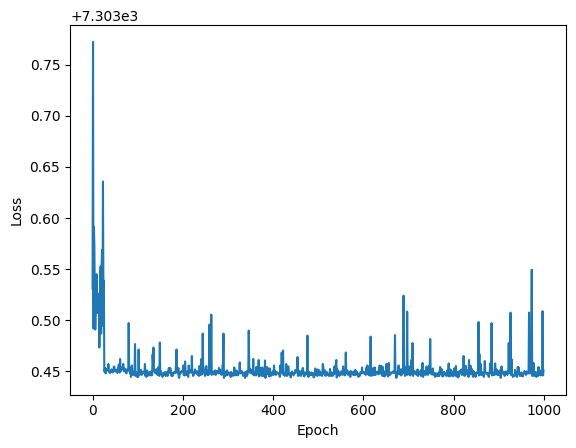

In [37]:
num_epochs = 1000
learning_rate = 5

# Use jnp.array to ensure compatibility with JAX
small_dataset = jnp.array(dataset[:1000])

def loss_fn(params_encoder, params_decoder, batch):
    encoded = encoder(batch, params_encoder)
    decoded = decoder(encoded, params_decoder)
    return jnp.mean((batch - decoded) ** 2)

history_loss = []

for epoch in range(num_epochs):
    # Compute gradients for the entire batch
    grad_encoder, grad_decoder = jax.grad(loss_fn, argnums=(0, 1))(params_encoder, params_decoder, small_dataset)
    
    # Update weights
    params_encoder = [p - learning_rate * g for p, g in zip(params_encoder, grad_encoder)]
    params_decoder = [p - learning_rate * g for p, g in zip(params_decoder, grad_decoder)]
    
    current_loss = loss_fn(params_encoder, params_decoder, small_dataset)
    history_loss.append(current_loss)
    if epoch % 50 == 0:
        current_loss = loss_fn(params_encoder, params_decoder, small_dataset)
        print(f"Epoch {epoch}, Loss: {current_loss}")

    # plot the history loss
plt.plot(history_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
